In [9]:
# Setup path to import src
import sys
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.utils.cds_plotter import CDSPlotter

In [10]:
from src.utils import config
# Example usage with new paths:
# plotter = CDSPlotter()
# plotter.load_data('GARCH', config.OUTPUT_DIR / 'cds_spreads_garch_mc.csv')

# CDS Spread Visualization

This notebook demonstrates how to use the `CDSPlotter` class to visualize CDS spreads from different models.

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import importlib
from src.utils import cds_plotter

# Force reload to pick up changes
importlib.reload(cds_plotter)
from src.utils.cds_plotter import CDSPlotter

In [13]:
# Initialize the plotter
plotter = CDSPlotter()

# Load the data using config paths
from src.utils import config

# Check if files exist before loading
garch_file = config.OUTPUT_DIR / 'cds_spreads_garch_mc_all_firms.csv'
rs_file = config.OUTPUT_DIR / 'cds_spreads_regime_switching_mc_all_firms.csv'
ms_garch_file = config.OUTPUT_DIR / 'cds_spreads_ms_garch_mc_all_firms.csv'
if garch_file.exists():
    plotter.load_data('GARCH', garch_file)
else:
    print(f"Warning: {garch_file} not found.")

if rs_file.exists():
    plotter.load_data('Regime Switching', rs_file)
else:
    print(f"Warning: {rs_file} not found.")
    
if ms_garch_file.exists():
    plotter.load_data('MS-GARCH', ms_garch_file)
else:
    print(f"Warning: {ms_garch_file} not found.")

Loading data for GARCH from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/cds_spreads_garch_mc_all_firms.csv...
  Mapped columns: ['spread_1y_bps', 'spread_3y_bps', 'spread_5y_bps']
  Successfully loaded 114742 rows for GARCH.
Loading data for Regime Switching from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/cds_spreads_regime_switching_mc_all_firms.csv...
  Mapped columns: ['spread_1y_bps', 'spread_3y_bps', 'spread_5y_bps']
  Successfully loaded 114742 rows for Regime Switching.
Loading data for MS-GARCH from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/cds_spreads_ms_garch_mc_all_firms.csv...
  Mapped columns: ['spread_1y_bps', 'spread_3y_bps', 'spread_5y_bps']
  Successfully loaded 114742 rows for MS-GARCH.


## 1. GARCH Model Results
Visualizing the term structure of CDS spreads over time for the GARCH model.

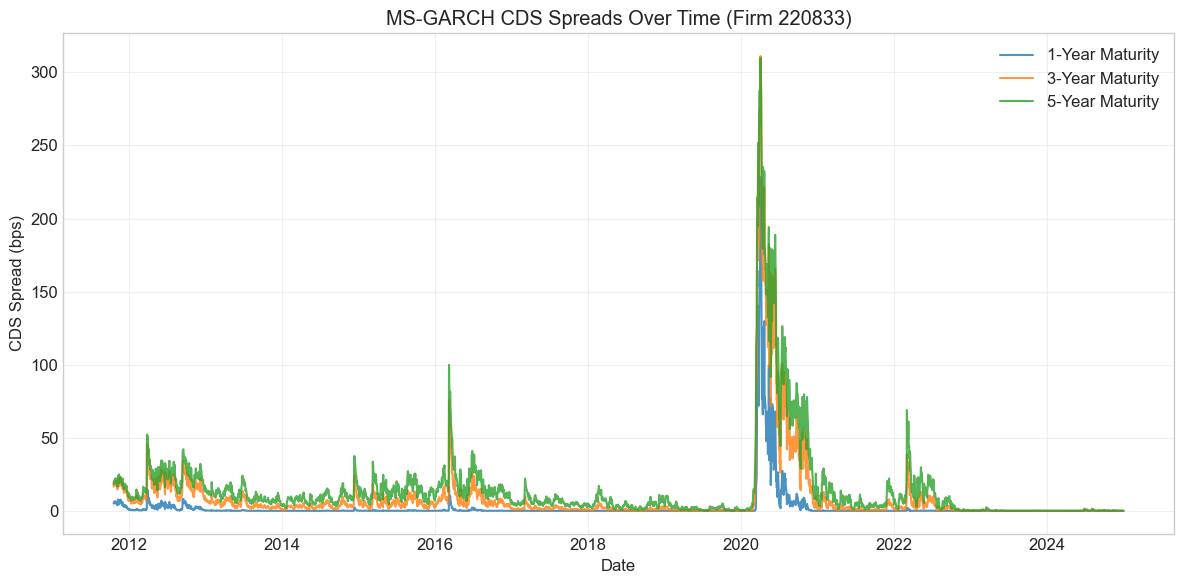

In [14]:
# Plot for firm 14447 
plotter.plot_spreads_over_time('MS-GARCH', gvkey=220833, maturities=[1, 3, 5])

## 2. Regime Switching Model Results
Visualizing the term structure of CDS spreads over time for the Regime Switching model.

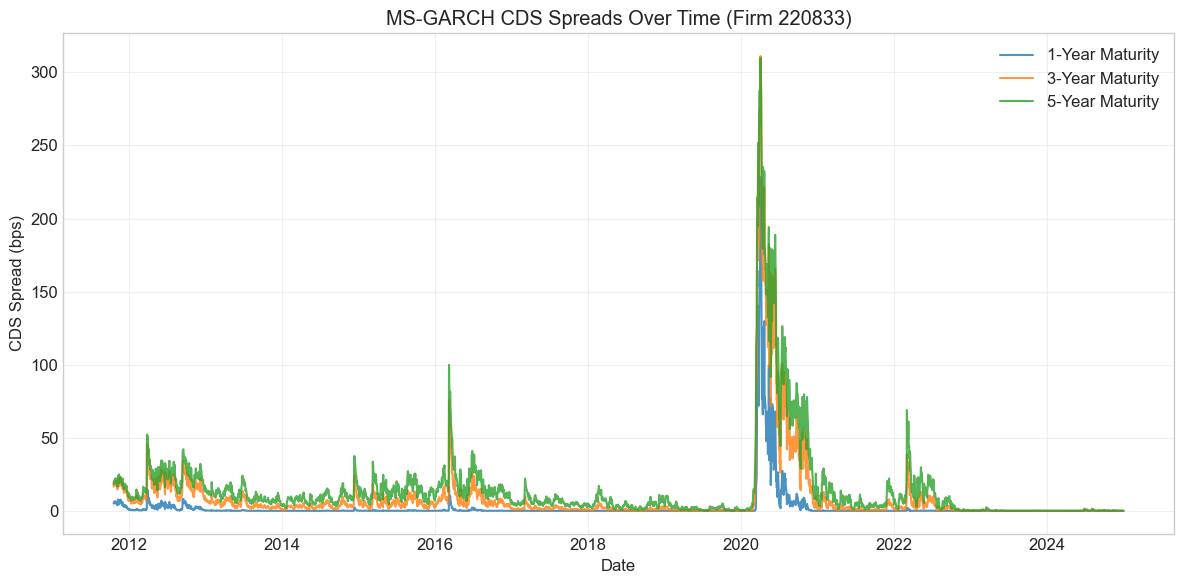

In [15]:
plotter.plot_spreads_over_time('MS-GARCH', gvkey=220833, maturities=[1, 3, 5])

## 3. Model Comparison
Comparing the 5-year CDS spread estimates between models.

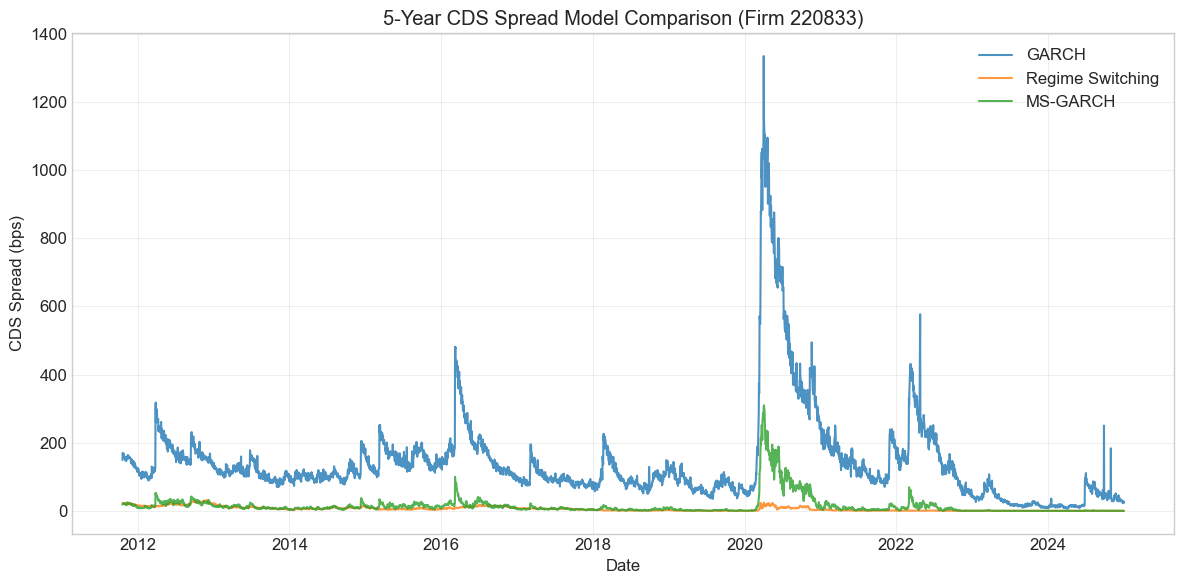

In [16]:
plotter.plot_model_comparison(gvkey=220833, maturity=5, models=['GARCH', 'Regime Switching', 'MS-GARCH'])

## 4. Average Spreads Across All Firms
Visualizing the average CDS spreads for all firms in the dataset (GARCH model).

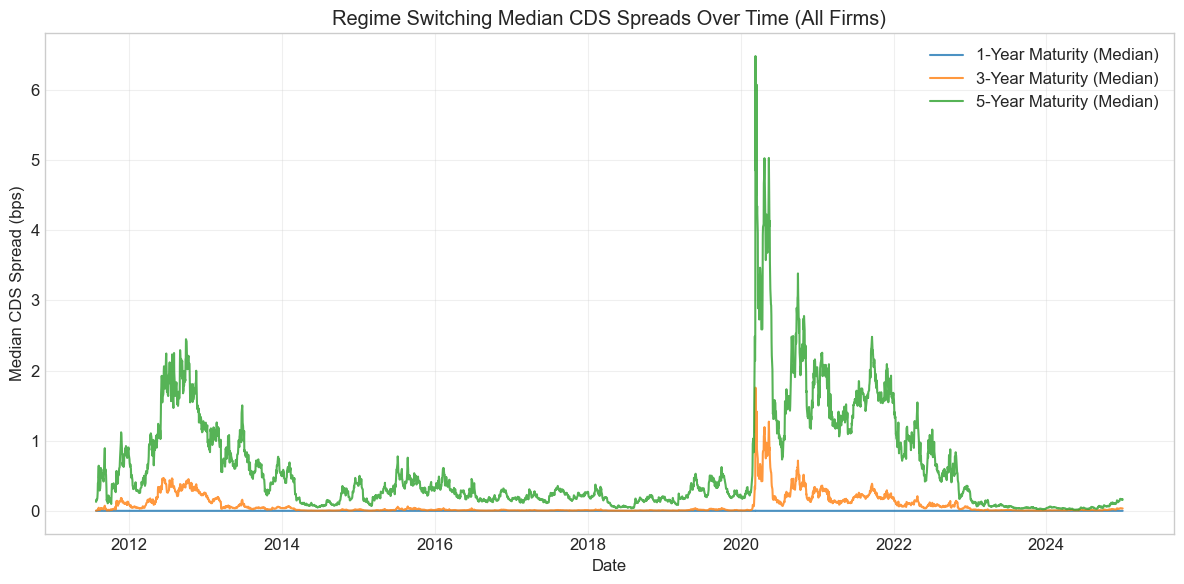

In [17]:
plotter.plot_average_spreads_over_time('Regime Switching', maturities=[1, 3, 5])